# DoubleML for Flexible Covariate Adjustment in Regression Discontinuity Designs (RDD)

This notebook demonstrates how to use RDD designs within ``DoubleML``. Our implementation ``RDFlex`` follows the work from [Noack, Olma and Rothe (2024)](https://arxiv.org/abs/2107.07942). 

In RDD treatment assignment is determined by a continuous running variable ("score", $S$) crossing a known threshold ("cutoff", $c$). We aim to estimate the local average treatment effect 
$$\theta_{0} = \mathbb{E}[Y_i(1)-Y_i(0)\mid S = c]$$
at the cutoff value. We therefore assume, that individuals are not able to manipulate their score in the neighborhood of the cutoff, and that there is a discontinuity in outcome which is sorely to be explained by the score.

In [1]:
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objs as go
from statsmodels.nonparametric.kernel_regression import KernelReg

from lightgbm import LGBMRegressor, LGBMClassifier

from rdrobust import rdrobust

import doubleml as dml
from doubleml.rdd import RDFlex
from doubleml.rdd.datasets import make_simple_rdd_data

## Sharp RDD

In the sharp design, the treatment assignment is deterministic given the score. Namely, all the individuals with a score higher than the cutoff, receive the treatment $$D_i = \mathbb{I}[S_i > c].$$

### Generate Data

The function ``make_simple_rdd_data()`` can be used to generate data of a rather standard RDD setting. If we set ``fuzzy = False``, the generated data follows a sharp RDD. We also generate covariates $X$ that can be used to adjust the estimation at a later stage.

In [2]:
np.random.seed(123)

fuzzy = False
data_dict = make_simple_rdd_data(n_obs=1000, fuzzy=fuzzy)

cov_names = ['x' + str(i) for i in range(data_dict['X'].shape[1])]
df = pd.DataFrame(
    np.column_stack((data_dict['Y'], data_dict['D'], data_dict['score'], data_dict['X'])),
    columns=['y', 'd', 'score'] + cov_names,
)
df.head()

,y,d,score,x0,x1,x2
0,1.524407,0.0,-1.085631,0.484418,-0.639093,-0.556110
1,11.843350,1.0,0.997345,0.399618,0.589009,0.906710
2,1.278325,1.0,0.282978,-0.382700,0.097267,-0.706374
3,-0.316781,0.0,-1.506295,-0.126210,-0.477759,-0.302400
4,5.924320,0.0,-0.578600,0.606731,0.606459,0.409011


In [3]:
fig = px.scatter(
    x=df['score'],
    y=df['y'],
    color=df['d'].astype(bool),
    labels={
        "x": "Score",   
        "y": "Outcome",
        "color": "Treatment"
    },
    title="Scatter Plot of Outcome vs. Score by Treatment Status"
)

fig.update_layout(
    xaxis_title="Score",
    yaxis_title="Outcome"
)
fig.show()

C:\Users\BAQ7040\AppData\Roaming\Python\Python311\site-packages\plotly\express\_core.py:1979: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


### Oracle Values and Comparisons

The generated oracle values for the potential outcomes can be used in a kernel regression to get an oracle estimator at the cutoff. 

In [4]:
ite = data_dict['oracle_values']['Y1'] - data_dict['oracle_values']['Y0']
score = data_dict['score']

oracle_model = KernelReg(endog=ite, exog=score, reg_type='ll', var_type='c', ckertype='gaussian')

score_grid = np.linspace(-1, 1, 100)
oracle_effects_sharp, _ = oracle_model.fit(score_grid)


scatter = go.Scatter(
    x=score,
    y=ite,
    mode='markers',
    name='ITE',
    marker=dict(color='blue')
)
line = go.Scatter(
    x=score_grid,
    y=oracle_effects_sharp,
    mode='lines',
    name='Average Effect Estimate',
    line=dict(color='red')
)


fig = go.Figure(data=[scatter, line])
fig.update_layout(
    title='Locally Linear Kernel Regression of ITE on Score',
    xaxis_title='Score',
    yaxis_title='Effect',
    legend=dict(x=0.8, y=0.2)
)

print(f"The oracle LATE is estimated as {oracle_model.fit([0])[0][0]}")

fig.show()

The oracle LATE is estimated as 0.977950766577146


### RDD with Linear Adjustment

The standard RDD estimator for the sharp design takes the form 

$$\hat{\theta}_{\text{SRD}}(h) = \sum_{i=1}^n w_i(h)(Y_i-X_i^T\hat{\gamma}_h)$$

where $w_i(h)$ are local linear regression weights that depend on the data through the realizations of the running variable $S_i$ only and $h>0$ is a bandwidth. $\hat{\gamma}_h$ is a minimizer.

The packages ``rdrobust`` implements this estimation with a linear adjustment.

In [5]:
rdrobust_sharp = rdrobust(y=df['y'], x=df['score'], fuzzy=df['d'], covs=df[cov_names], c=0.0)
rdrobust_sharp

Call: rdrobust
Number of Observations:                  1000
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           520        480
Number of Unique Obs.            520        480
Number of Effective Obs.         272        241
Bandwidth Estimation            0.69       0.69
Bandwidth Bias                 1.096      1.096
rho (h/b)                      0.629      0.629

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       1.247    0.485     2.57   1.017e-02     [0.296, 2.198]
Robust                 -        -    2.293   2.184e-02       [0.19, 2.42]


### RDD with flexible adjustment

[Noack, Olma and Rothe (2024)](https://arxiv.org/abs/2107.07942) propose an estimator that reduces the variance of the above esimator, using a flexible adjustment of the outcome by ML. For more details, see our User Guide. The estimator here takes the form 

$$\hat{\theta}_{\text{RDFlex}}(h) = \sum_{i=1}^n w_i(h)M_i(\eta),\quad M_i(\eta) = Y_i - \eta(X_i),$$


with $\eta(\cdot)$ being potentially nonlinear adjustment functions.

We initialize a `DoubleMLData` object using the usual package syntax.

Note: `x_cols` refers to the covariates to be adjusted for, and `s_col` is the score. `y_col` is the observed outcome, on which we want to estimate the effect at the cutoff. In the sharp design, `d_cols` is an indicator whether an observation is left or right of the cutoff ($\mathbb{I}[S_i > c]$).

In [6]:
dml_data = dml.DoubleMLData(df, y_col='y', d_cols='d', x_cols=cov_names, s_col='score')

The ``RDFlex`` object is intialized with only one learner, that adjusts the outcome based on the covariates.

In [7]:
ml_g = LGBMRegressor(n_estimators=500, learning_rate=0.01, verbose=-1)

rdflex_sharp = RDFlex(dml_data,
                      ml_g,
                      fuzzy=False,
                      n_folds=5,
                      n_rep=1)
rdflex_sharp.fit(n_iterations=2)

print(rdflex_sharp)

Method             Coef.     S.E.     t-stat       P>|t|           95% CI
-------------------------------------------------------------------------
Conventional      1.030     0.129     7.973    1.549e-15  [0.777, 1.283]
Robust                 -        -     6.736    1.626e-11  [0.702, 1.279]


It is visible that the flexible adjustment decreases the standard error in the estimation and therefore provides tighter confidence intervals.

## Fuzzy RDD

In the fuzzy design, the treatment assignment is still deterministic given the score ($T_i = \mathbb{I}[S_i > c]$).
However, in the neighborhood of the cutoff, there is a probability of observations not picking up the treatment they were assignt. These observations cause the probability jump of treatment at the cutoff to be smaller than 1.

### Generate Data

The function ``make_simple_rdd_data()`` with ``fuzzy = True`` generates basic data for the fuzzy case.

In [8]:
np.random.seed(42)

fuzzy = True
data_dict = make_simple_rdd_data(n_obs=1000, fuzzy=fuzzy)

cov_names = ['x' + str(i) for i in range(data_dict['X'].shape[1])]
df = pd.DataFrame(
    np.column_stack((data_dict['Y'], data_dict['D'], data_dict['score'], data_dict['X'])),
    columns=['y', 'd', 'score'] + cov_names,
)
df.head()

,y,d,score,x0,x1,x2
0,2.131533,1.0,0.496714,-0.665035,-0.790864,0.272860
1,10.104291,1.0,-0.138264,0.412951,-0.936828,0.872424
2,3.337677,1.0,0.647689,-0.896057,0.082593,0.418121
3,7.767124,1.0,1.523030,0.741938,0.428174,0.603456
4,4.209740,1.0,-0.234153,-0.321100,0.629650,-0.839770


In [9]:
fig = px.scatter(
    x=df['score'],
    y=df['y'],
    color=df['d'].astype(bool),
    labels={
        "x": "Score",   
        "y": "Outcome",
        "color": "Treatment"
    },
    title="Scatter Plot of Outcome vs. Score by Treatment Status"
)

fig.update_layout(
    xaxis_title="Score",
    yaxis_title="Outcome"
)
fig.show()

C:\Users\BAQ7040\AppData\Roaming\Python\Python311\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



### Oracle Values and Comparisons

The generated oracle values for the potential outcomes can be used in a kernel regression to get an oracle estimator at the cutoff. 

Since in the fuzzy design we calculate the treatment effect on the treated, we drop observation that did not follow the treatment assignment for the oracle computation.

In [10]:
complier_mask = ((data_dict["score"] < 0) & (data_dict["D"] == False)) | ((data_dict["score"] > 0) & (data_dict["D"] == True))
ite = data_dict['oracle_values']['Y1'][complier_mask] - data_dict['oracle_values']['Y0'][complier_mask]
score = data_dict['score'][complier_mask]

oracle_model = KernelReg(endog=ite, exog=score, reg_type='ll', var_type='c', ckertype='gaussian')

score_grid = np.linspace(-1, 1, 100)
oracle_effects_fuzzy, _ = oracle_model.fit(score_grid)


scatter = go.Scatter(
    x=score,
    y=ite,
    mode='markers',
    name='ITE',
    marker=dict(color='blue')
)
line = go.Scatter(
    x=score_grid,
    y=oracle_effects_fuzzy,
    mode='lines',
    name='Average Effect Estimate',
    line=dict(color='red')
)


fig = go.Figure(data=[scatter, line])
fig.update_layout(
    title='Locally Linear Kernel Regression of ITE on Score',
    xaxis_title='Score',
    yaxis_title='Effect',
    legend=dict(x=0.8, y=0.2)
)

print(f"The oracle LATE is estimated as {oracle_model.fit([0])[0][0]}")

fig.show()

The oracle LATE is estimated as 0.9087280080883967


### RDD with Linear Adjustment

The standard RDD estimator for the fuzzy design takes the form 

$$\hat{\theta}_{\text{FRD}}(h) = \frac{\hat{\theta}_{\text{SRD}}(h)}{\hat{\theta}_{\text{D}}(h)} = \frac{\sum_{i=1}^n w_i(h)(Y_i-X_i^T\hat{\gamma}_{Y, h})}{\sum_{i=1}^n w_i(h)(D_i-X_i^T\hat{\gamma}_{D, h})}$$

Under the assumption, that there are no *Defiers* (= individuals that would always pick the opposite treatment of their assigned one), this effect can be interpreted as *Average Treatment Effect on the Treated*. The package ``rdrobust`` implements this estimation with a linear adjustment.

In [11]:
rdrobust_fuzzy = rdrobust(y=df['y'], x=df['score'], fuzzy=df['d'], covs=df[cov_names], c=0.0)
rdrobust_fuzzy

Call: rdrobust
Number of Observations:                  1000
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           490        510
Number of Unique Obs.            490        510
Number of Effective Obs.         244        263
Bandwidth Estimation           0.653      0.653
Bandwidth Bias                 1.023      1.023
rho (h/b)                      0.638      0.638

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       2.798     3.98    0.703   4.821e-01   [-5.003, 10.598]
Robust                 -        -    0.717   4.735e-01   [-5.806, 12.502]


### RDD with flexible adjustment

[Noack, Olma and Rothe (2024)](https://arxiv.org/abs/2107.07942) propose an estimator that reduces the variance of the above esimator, using a flexible adjustment of the outcome by ML. For more details, see our user guide. The estimator here takes the form 

$$\hat{\theta}_{\text{RDFlex, FRD}}(h) = \frac{\sum_{i=1}^n w_i(h)(Y_i - \hat{\eta}_Y(X_i))}{\sum_{i=1}^n w_i(h)(D_i - \hat{\eta}_D(X_i))},$$


with $\eta_Y(\cdot), \eta_D(\cdot)$ being potentially nonlinear adjustment functions.

We initialize a `DoubleMLData` object using the usual package syntax.

Note: `x_cols` refers to the covariates to be adjusted for, and `s_col` is the score. `d_cols` in the fuzzy case has to be the treatment received.

In [12]:
dml_data = dml.DoubleMLData(df, y_col='y', d_cols='d', x_cols=cov_names, s_col='score')

This time, we also have to specify a classifier that adjusts the treatment assignment probabilities.

In [13]:
ml_g = LGBMRegressor(n_estimators=500, learning_rate=0.01, verbose=-1)
ml_m = LGBMClassifier(n_estimators=500, learning_rate=0.01, verbose=-1)

rdflex_fuzzy = RDFlex(dml_data,
                      ml_g,
                      ml_m,
                      fuzzy=True,
                      n_folds=5,
                      n_rep=1)
rdflex_fuzzy.fit(n_iterations=2)

print(rdflex_fuzzy)

Method             Coef.     S.E.     t-stat       P>|t|           95% CI
-------------------------------------------------------------------------
Conventional      3.259     2.007     1.624    1.044e-01  [-0.674, 7.192]
Robust                 -        -     1.668    9.527e-02  [-0.692, 8.607]


Also for the fuzzy case, we observe a significant decrease in estimation standard error.

### Advanced: Global and Local Learners, Stacked Ensembles

By default, ``RDFlex`` fits the ML methods using kernel weights, there fore it is a "local" fit around the cutoff. If the adjustment should also compain "global" information from the full support of $S$ available in the data, the use of a ``GlobalLearner`` is recommended. The learners can also be stacked. All learners have to support the `sample_weight` in their `fit` method. By stacking and using local and global learners, it is possible to further tune the estimation and potentially reduce standard errors even further.

In [14]:
from doubleml.utils import GlobalRegressor, GlobalClassifier

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import StackingClassifier, StackingRegressor

In [15]:
reg_estimators = [
    ('lr local', LinearRegression()),
    ('rf local', RandomForestRegressor()),
    ('lr global', GlobalRegressor(base_estimator=LinearRegression())),
    ('rf global', GlobalRegressor(base_estimator=RandomForestRegressor()))
]

class_estimators = [
    ('lr local', LogisticRegression()),
    ('rf local', RandomForestClassifier()),
    ('lr global', GlobalClassifier(base_estimator=LogisticRegression())),
    ('rf global', GlobalClassifier(base_estimator=RandomForestClassifier()))
]

ml_g = StackingRegressor(
    estimators=reg_estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=42)
)

ml_m = StackingClassifier(
    estimators=class_estimators,
    final_estimator=RandomForestClassifier(n_estimators=10,
                                           random_state=42)
)

In [17]:
rdflex_fuzzy_stack = RDFlex(dml_data,
                            ml_g,
                            ml_m,
                            fuzzy=fuzzy,
                            n_folds=5,
                            n_rep=1)
rdflex_fuzzy_stack.fit(n_iterations=2)

print(rdflex_fuzzy_stack)

Method             Coef.     S.E.     t-stat       P>|t|           95% CI
-------------------------------------------------------------------------
Conventional      1.919     1.142     1.680    9.291e-02  [-0.319, 4.157]
Robust                 -        -     1.514    1.300e-01  [-0.611, 4.759]


For a conclusion, we look at a visualization of the estimated coefficient and the confidence intervals. We see that by using the flexible adjustment, it is possible to shrink confidence bands.

In [18]:
df_sharp = pd.DataFrame({"coef": [rdrobust_sharp.coef.values[0][0], rdflex_sharp.coef[0]],
                         "CI lower": [rdrobust_sharp.ci.values[0][0], rdflex_sharp.confint().values[0][0]],
                         "CI upper": [rdrobust_sharp.ci.values[0][1], rdflex_sharp.confint().values[0][1]],
                         "method": ["Linear Adj.", "Flexible Adj."]})
df_fuzzy = pd.DataFrame({"coef": [rdrobust_fuzzy.coef.values[0][0], rdflex_fuzzy.coef[0], rdflex_fuzzy_stack.coef[0]],
                         "CI lower": [rdrobust_fuzzy.ci.values[0][0], rdflex_fuzzy.confint().values[0][0], rdflex_fuzzy_stack.confint().values[0][0]],
                         "CI upper": [rdrobust_fuzzy.ci.values[0][1], rdflex_fuzzy.confint().values[0][1], rdflex_fuzzy_stack.confint().values[0][1]],
                         "method": ["Linear Adj.", "Flexible Adj.", "Flexible Adj. (Stacked)"]})

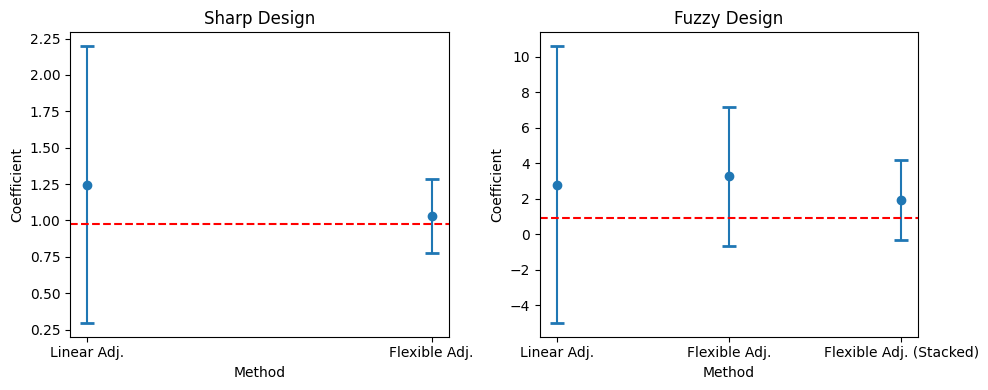

In [19]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].errorbar(
    df_sharp['method'],
    df_sharp['coef'],
    yerr=(df_sharp['coef'] - df_sharp['CI lower'], df_sharp['CI upper'] - df_sharp['coef']),
    fmt='o',
    capsize=5,
    capthick=2
)
axes[0].set_title('Sharp Design')
axes[0].set_ylabel('Coefficient')
axes[0].set_xlabel('Method')
axes[0].axhline(oracle_effects_sharp[49:51].mean(), linestyle="--", color="r")

axes[1].errorbar(
    df_fuzzy['method'],
    df_fuzzy['coef'],
    yerr=(df_fuzzy['coef'] - df_fuzzy['CI lower'], df_fuzzy['CI upper'] - df_fuzzy['coef']),
    fmt='o',
    capsize=5,
    capthick=2
)
axes[1].set_title('Fuzzy Design')
axes[1].set_ylabel('Coefficient')  
axes[1].set_xlabel('Method')
axes[1].axhline(oracle_effects_fuzzy[49:51].mean(), linestyle="--", color="r")

plt.tight_layout()